# Gene enrichment on BRICK
This is an example for GeneSet Enrichment based on BRICK. Generally speaking, the gene sets obtained from omics analysis are overly redundant gene sets, and the genes in them are also heterogeneous in function. BRICK can group genes according to their functions and expression levels in omics data. While indicating the associated entities of the gene sets, it further resolves the heterogeneity of genes in function.

## Loading Packages and Data

In [1]:
import scanpy as sc
import pandas as pd
import BRICK


In [2]:
url = "neo4j://10.224.28.66:7687"
auth = ("neo4j", "bmVvNGpwYXNzd29yZA==")  

BRICK.config(url=url, auth=auth)

BRICK.config_llm(modeltype='ChatOpenAI', 
                 api_key="sk-kpsteSkpDGl1xBmDEcC7D51b968e43499092826f17286b55",  
                 base_url='http://10.224.28.80:3000/v1', 
                 llm_params={'model_name': 'qwen-max'})

Graph database has been configured and initialized successfully.
LLM has been configured and initialized successfully.


In [3]:
adata = sc.read('./data/adata_new1.h5ad')
adata.X = adata.layers['lognorm'].copy()
sc.tl.rank_genes_groups(adata, groupby='KGannotator_refinement', pts=True)

adata

AnnData object with n_obs × n_vars = 822 × 14821
    obs: 'sample_name', 'n_genes', 'n_counts', 'annotation', 'leiden', 'KGannotator2', 'delta_specific', 'gamma_specific', 'leiden_combined', 'KGannotator_refinement'
    var: 'Ensembl_id', 'Symbol', 'NCBI_id', 'MGI_id', 'mean', 'std'
    uns: 'KGannotator2_colors', 'KGannotator_refinement_colors', 'leiden', 'log1p', 'neighbors', 'pca', 'rank_genes_groups', 'umap'
    obsm: 'X_pca', 'X_umap', 'annotation_au'
    varm: 'PCs'
    layers: 'lognorm'
    obsp: 'connectivities', 'distances'

## Get Gene Set to Enrich

Here we take pancreatic PP cell as an example, and use top 100 genes to enrich.

In [4]:
BRICK.pp.rank_genes_groups2df(adata)
genelist = list(adata.uns['rank_genes_groups_df']['pancreatic PP cell']['names'])[:100]

In [8]:
# query entities related to genelist. To check available relation type, call: BRICK.help.check_relation_type(source_entity_type='Gene')
query_df = BRICK.qr.query_neighbor(genelist, 
                                   target_entity_type=['Cell', 'Tissue', 'Disease','Phenotype', 
                                                       'Chemical',  'Process', 'Function', 
                                                       'Cell_Component', 'Pathway'], 
                                   relation=['marker_of', 'participate_in', 'causally_related_to', 
                                             'capable_of','spatially_related_to	', 'processly_related_to',
                                             'functionally_related_to', 'has_disease_phenotype_on',
                                             'pharmaco_effect_on'])

# rank target entities based on query result.
query_target_df = BRICK.rk.enrich(query_df)

query_target_df.head()

,path.0.name,path.1.relation,path.1.info_source_length,path.1.relation_confidence,path.2.id,path.2.name,path.2.type,path.2.match_count,path.2.background_count,path.2.enrich_statistic,path.2.enrich_pvalue
0,[Lpl],[capable_of],[1],[nan],GO:0052740,1-acyl-2-lysophosphatidylserine acylhydrolase activity,Function,1,18,11.223345,0.090373
1,"[Aplp1, Cpe, Gnas, Cnot6l]","[marker_of, marker_of, marker_of, marker_of]","[1, 1, 1, 1]","[[1], [1], [1], [1]]",EMAPA:36041,1-cell stage conceptus,Cell,4,640,1.262626,0.397767
2,"[Meg3, Pcsk1n, Ace2]","[marker_of, marker_of, marker_of]","[1, 1, 1]","[[1], [1], [1]]",EMAPA:16033,1-cell stage embryo,Tissue,3,322,1.882176,0.221572
3,"[Mbnl2, Isl1, Meis2, Maged1]","[marker_of, marker_of, marker_of, marker_of]","[1, 1, 1, 1]","[[1], [1], [1], [1]]",UBERON:0007237,1st arch mandibular component,Tissue,4,253,3.193995,0.041631
4,[Isl1],[marker_of],[2],"[[1, 1]]",UBERON:0013155,1st arch mandibular ectoderm,Tissue,1,42,4.810005,0.192845


filter target entity with p value cut off as 0.05

In [9]:
query_target_df_sub = query_target_df.loc[query_target_df['path.2.enrich_pvalue'] < 0.05]

## Cluster genes according to gene functions and visualize 

d:\downloads\nlp\kg_repo\BRICK\plotting\radial_enrich.py:71: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  tmp[a][b] += 1
d:\downloads\nlp\kg_repo\BRICK\plotting\radial_enrich.py:72: FutureWarning: ChainedAssignmentError: behaviour will chan

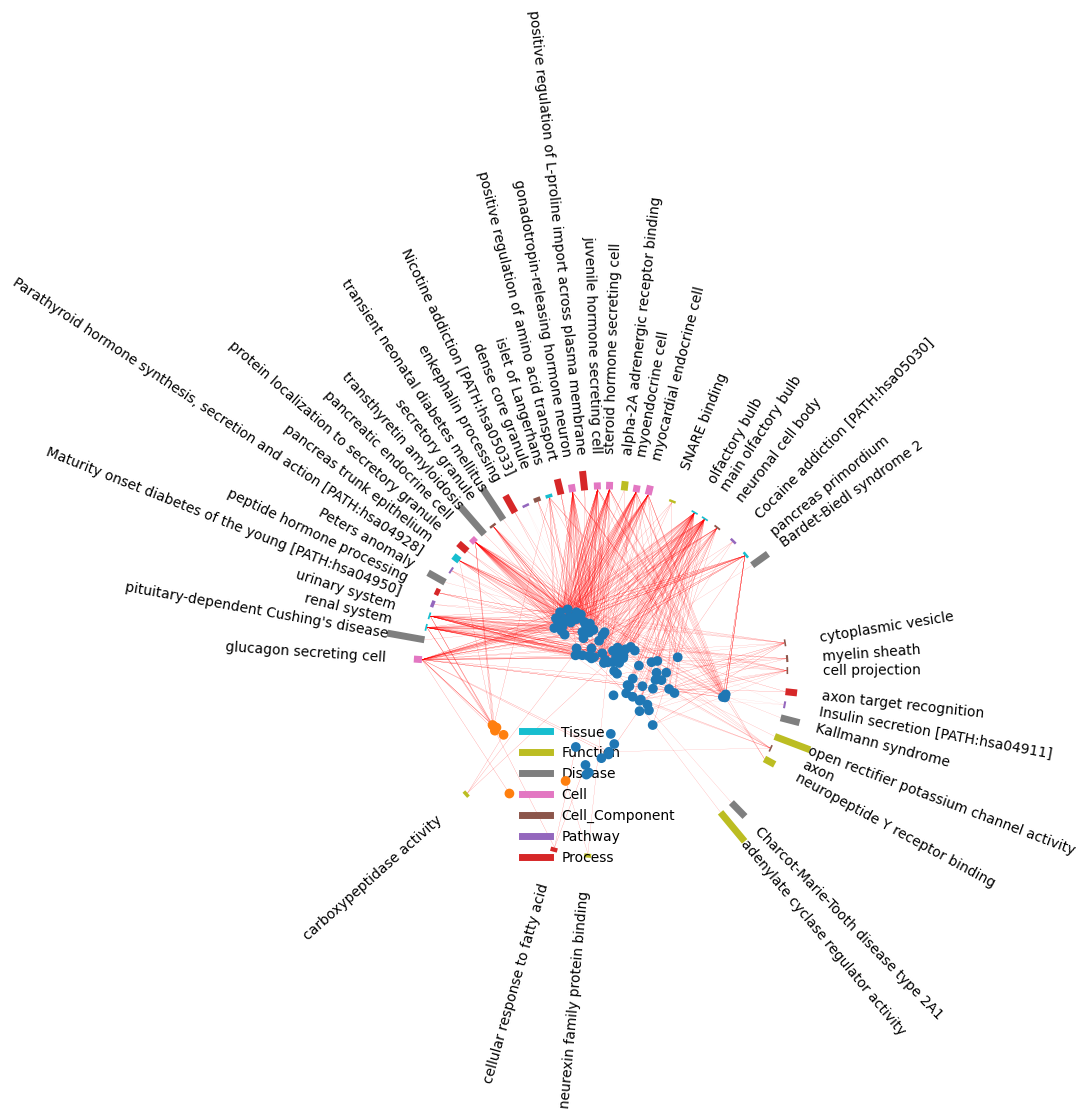

In [12]:
fig, gene_cluster = BRICK.pl.radial_enrich_plot(query_target_df_sub, return_cluster_result=True, leiden_resolution=0.1)

In [13]:
gene_cluster.obs.head()

,leiden
gene,
Nap1l5,0
Abcc8,0
Cpq,1
Xist,0
Ace2,0


## Interprete Enrichment result

In [14]:
BRICK.inp.gene_enrichment_analysis(query_target_df, gene_cluster)

d:\downloads\nlp\kg_repo\BRICK\interpretation.py:700: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for x, y in gene_cluster.obs.groupby('leiden'):


'### Interpretation of Gene Enrichment Results\n\n#### Table 1: Overall Gene Enrichment Analysis\n\n**Summary of Findings:**\n- The gene enrichment analysis in Table 1 reveals a wide range of cellular and tissue-specific functions, with a significant focus on endocrine and neuronal cell types.\n- The most enriched pathways include various types of hormone-secreting cells, such as glucagon-secreting cells, pancreatic endocrine cells, and steroid hormone-secreting cells. These findings suggest that the genes are highly involved in endocrine processes.\n- Other enriched pathways include neuronal cell bodies, secretory granules, and dense core granules, indicating a strong involvement in neuronal and secretory functions.\n\n**Key Conclusions:**\n- **Endocrine Functions:** The high enrichment in endocrine-related pathways (e.g., glucagon-secreting cells, pancreatic endocrine cells) suggests that the genes are crucial for hormone production and secretion.\n- **Neuronal Functions:** The enric